# Compute Rt for Haredim cities (Bnei-Brak, Elad, Modiin-Ilit, Beitar-Ilit)

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gp_zjbn3 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
dfcit = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False, cities=True)
bb = ['6100', '3780', '3797', '1309', '1137']
model_bb = dfcit.loc[bb].groupby('date').sum()
gmbb = GenerativeModel(bb, model_bb, buffer_days = 10, delay=2, sigma=0.07)
gmbb.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1176 seconds.


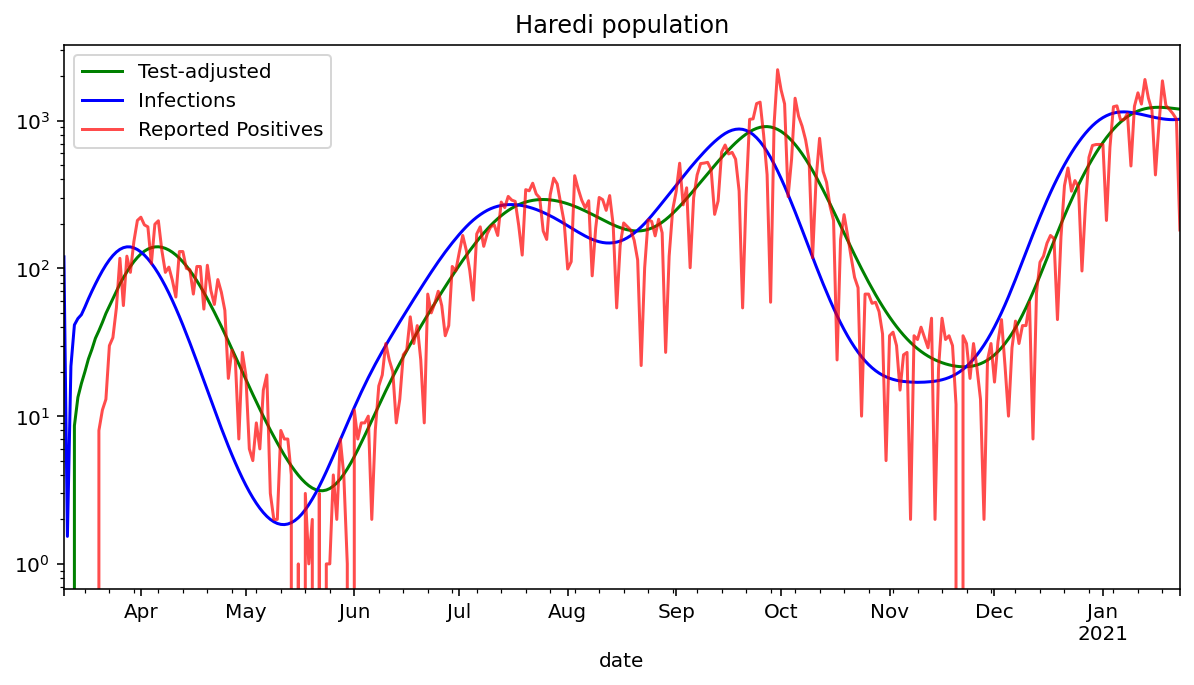

In [3]:
resultbb = summarize_inference_data(gmbb.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Haredi population")
resultbb.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultbb.infections.plot(c="b", label="Infections")
gmbb.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

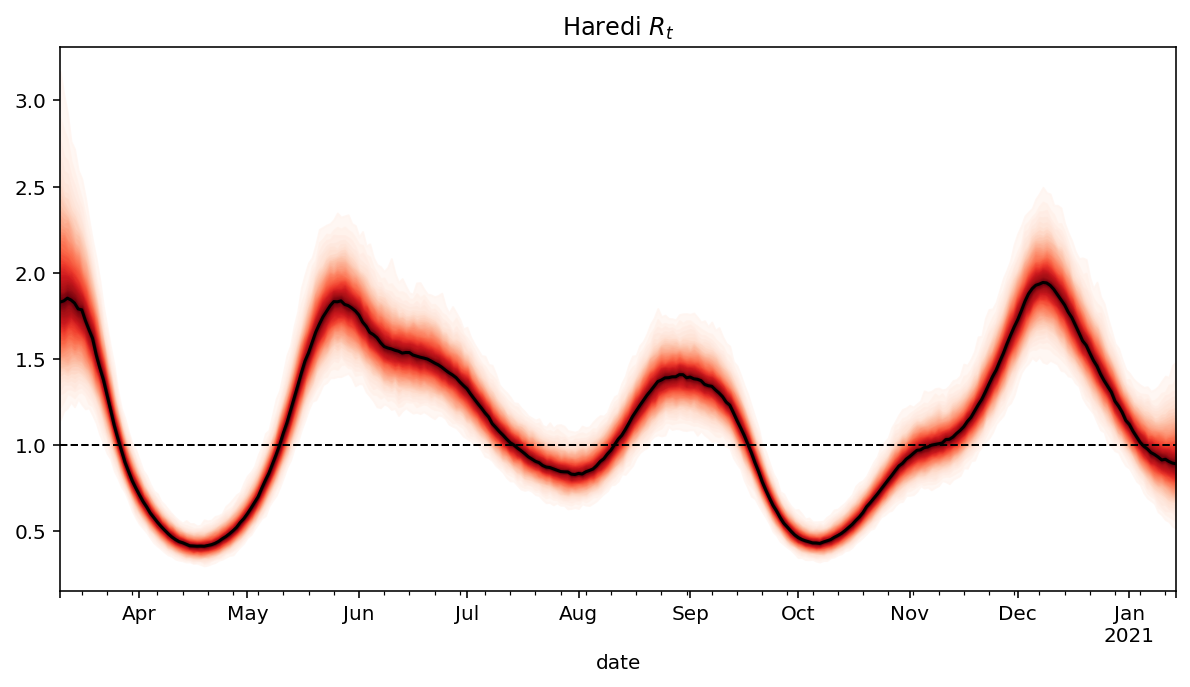

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Haredi $R_t$")
samples = gmbb.trace['r_t']
x=resultbb.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultbb["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [5]:
resultbb.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-25,1.444000,1.435605,1.233486,1.624893,24.316787,21.898985,31.0,31.0,500000
2020-11-26,1.494844,1.485750,1.265762,1.665308,25.986776,22.206539,21.0,21.0,500000
2020-11-27,1.541501,1.533025,1.306704,1.724758,27.945378,22.637456,13.0,13.0,500000
2020-11-28,1.598586,1.587840,1.361850,1.797314,30.262949,23.209811,2.0,2.0,500000
2020-11-29,1.649501,1.637992,1.414216,1.863556,33.012544,23.943438,24.0,24.0,500000
2020-11-30,1.693981,1.685609,1.431159,1.901611,36.285695,24.860353,31.0,31.0,500000
2020-12-01,1.744465,1.728404,1.508954,1.986421,40.177576,25.987551,17.0,17.0,500000
2020-12-02,1.791112,1.779308,1.538332,2.011057,44.773511,27.358325,32.0,32.0,500000
2020-12-03,1.842121,1.834476,1.582306,2.075890,50.212327,29.013957,45.0,45.0,500000


# General population

In [6]:
gn = ['5000', '8400', '8300', '1139', '2800', '9000', '2600', '6500', '6600', '6200', '9500']
model_gn = dfcit.loc[gn].groupby('date').sum()
gmgn = GenerativeModel(gn, model_gn, buffer_days = 10, delay=2, sigma=0.07)
gmgn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1398 seconds.


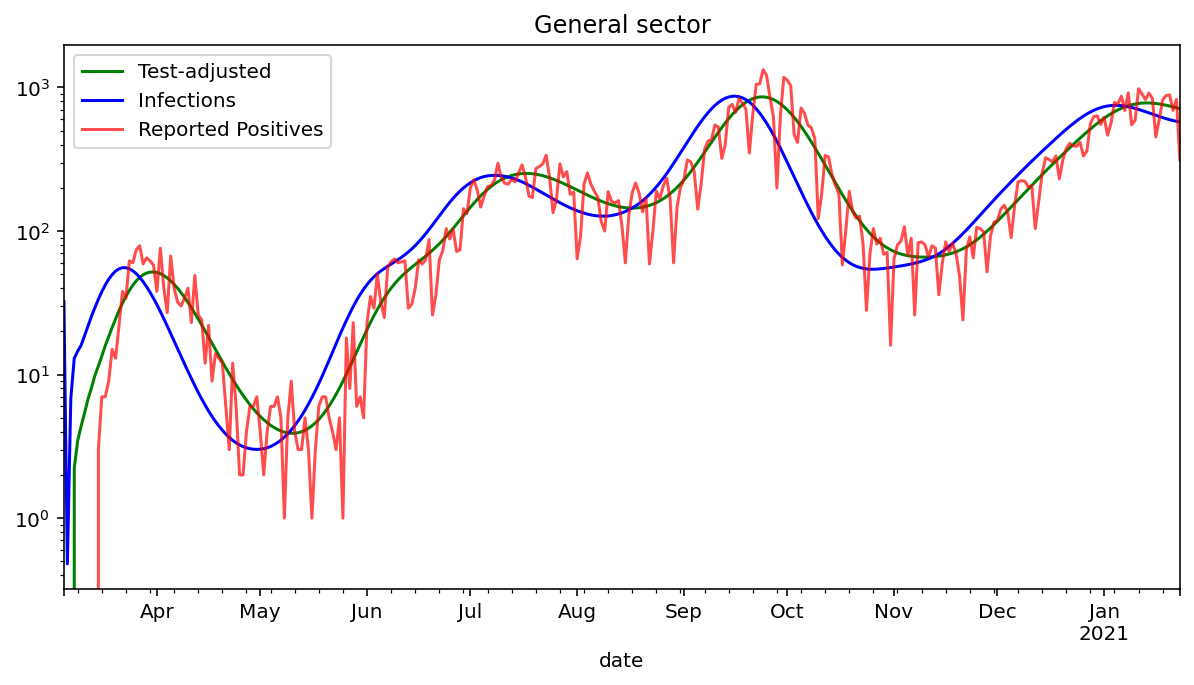

In [7]:
resultgn = summarize_inference_data(gmgn.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("General sector")
resultgn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultgn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgn.infections.plot(c="b", label="Infections")
gmgn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmgn.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

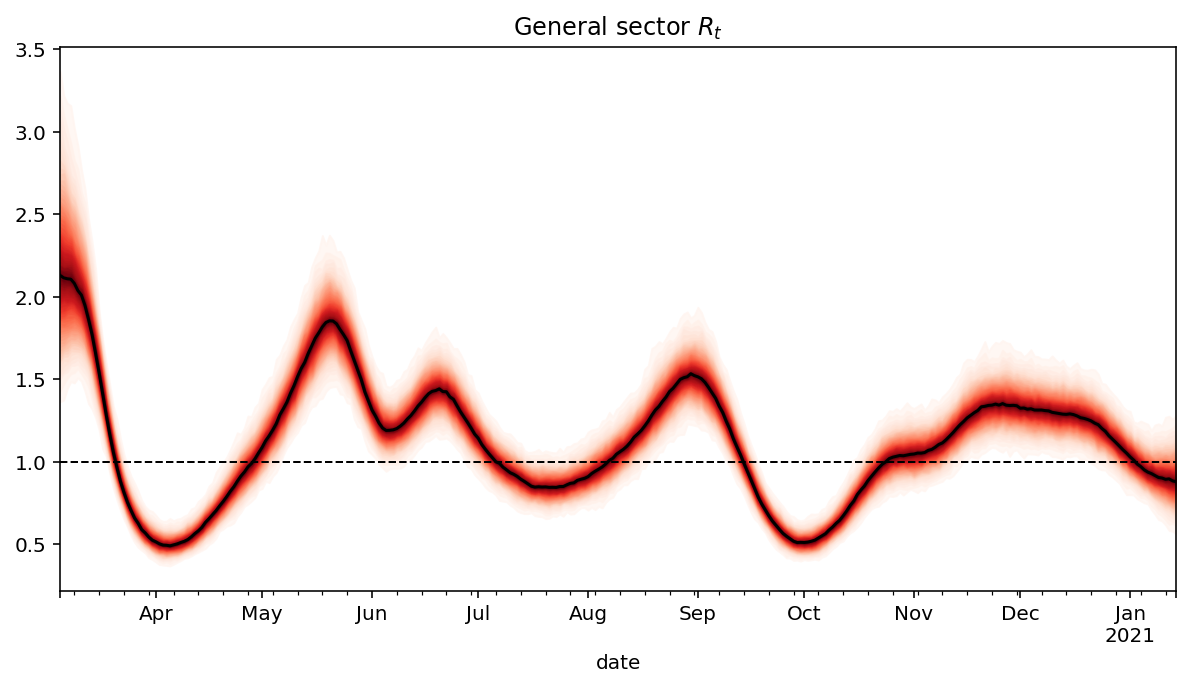

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"General sector $R_t$")
samples = gmgn.trace['r_t']
x=resultgn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultgn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [9]:
resultgn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-25,1.352407,1.342866,1.195222,1.516987,121.340330,86.682209,106.0,106.0,1100000
2020-11-26,1.360319,1.352318,1.208823,1.547230,128.940339,90.541052,104.0,104.0,1100000
2020-11-27,1.354018,1.342772,1.161993,1.510753,137.016550,94.849567,99.0,99.0,1100000
2020-11-28,1.351318,1.340567,1.179877,1.514877,145.666729,99.623931,52.0,52.0,1100000
2020-11-29,1.346235,1.341783,1.167578,1.497767,154.867449,104.877711,92.0,92.0,1100000
2020-11-30,1.343656,1.339302,1.166032,1.497226,164.535217,110.620884,115.0,115.0,1100000
2020-12-01,1.334696,1.324262,1.184048,1.520192,174.669785,116.867418,118.0,118.0,1100000
2020-12-02,1.333418,1.325442,1.146817,1.477862,185.310085,123.631124,142.0,142.0,1100000
2020-12-03,1.328231,1.318467,1.165599,1.493275,196.411845,130.918809,151.0,151.0,1100000


# Arab cities

In [10]:
ar = ['472', '2710', '6000', '2730', '2720', '8900', '509', '634', '7300', '7500', '531', '637', '638', '543', '8800']
model_ar = dfcit.loc[ar].groupby('date').sum()
gmar = GenerativeModel(ar, model_ar, buffer_days = 10, delay=2, sigma=0.07)
gmar.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1312 seconds.


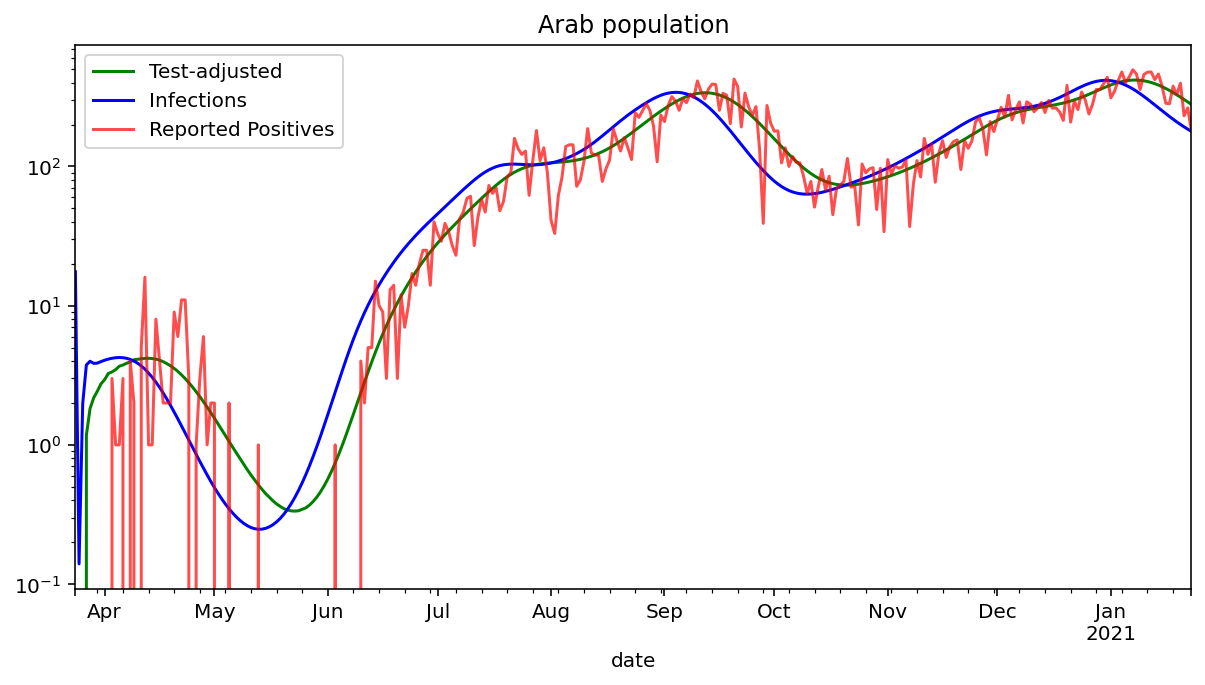

In [11]:
resultar = summarize_inference_data(gmar.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Arab population")
resultar.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultar.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultar.infections.plot(c="b", label="Infections")
gmar.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

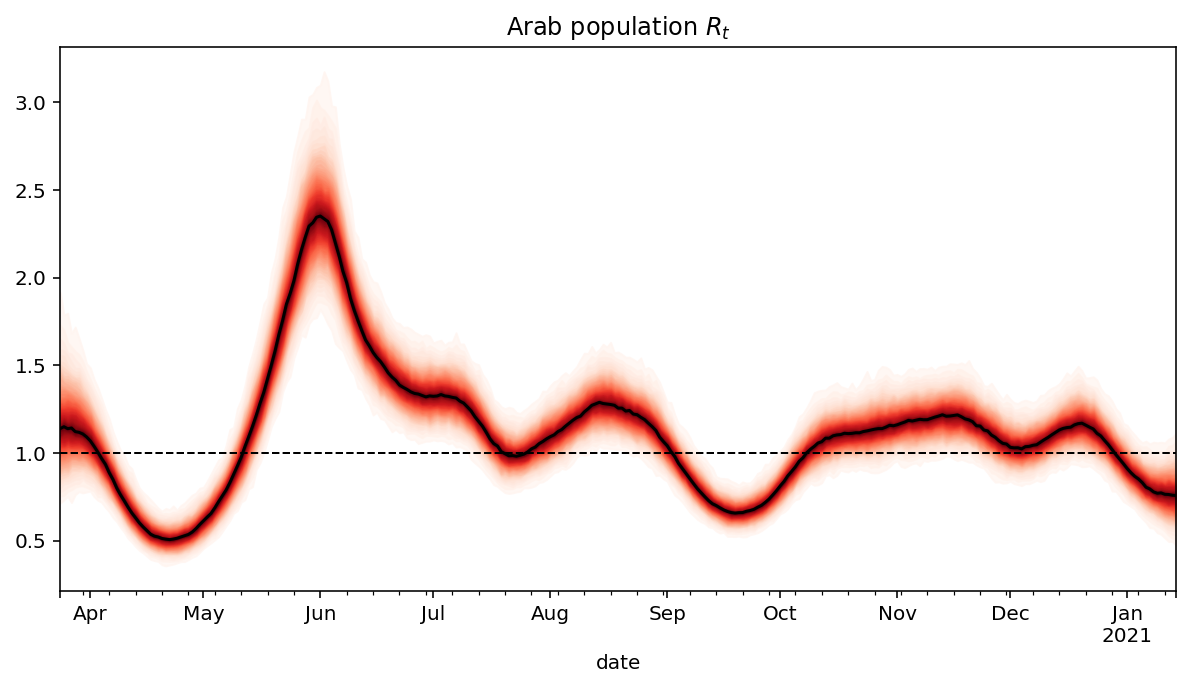

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Arab population $R_t$")
samples = gmar.trace['r_t']
x=resultar.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultar["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [13]:
resultar.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-25,1.124448,1.125184,0.966895,1.253105,223.869048,174.983089,209.0,209.0,1500000
2020-11-26,1.110000,1.101716,0.970373,1.245612,229.725272,181.517288,224.0,224.0,1500000
2020-11-27,1.094391,1.088942,0.932608,1.217681,235.109051,188.185454,187.0,187.0,1500000
2020-11-28,1.074110,1.069263,0.940598,1.219984,240.017642,194.921539,121.0,121.0,1500000
2020-11-29,1.060250,1.054381,0.929827,1.182328,244.374169,201.655001,210.0,210.0,1500000
2020-11-30,1.051648,1.050346,0.924512,1.192466,248.021518,208.314861,178.0,178.0,1500000
2020-12-01,1.041118,1.031556,0.876275,1.142254,250.970658,214.833900,218.0,218.0,1500000
2020-12-02,1.034411,1.028655,0.899099,1.148066,253.426652,221.146831,266.0,266.0,1500000
2020-12-03,1.031969,1.028853,0.886506,1.141086,255.473756,227.181879,226.0,226.0,1500000


In [14]:
jr = ['3000']
model_jr = dfcit.loc[jr].groupby('date').sum()
gmjr = GenerativeModel(jr, model_jr, buffer_days = 10, delay=2)
gmjr.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1238 seconds.


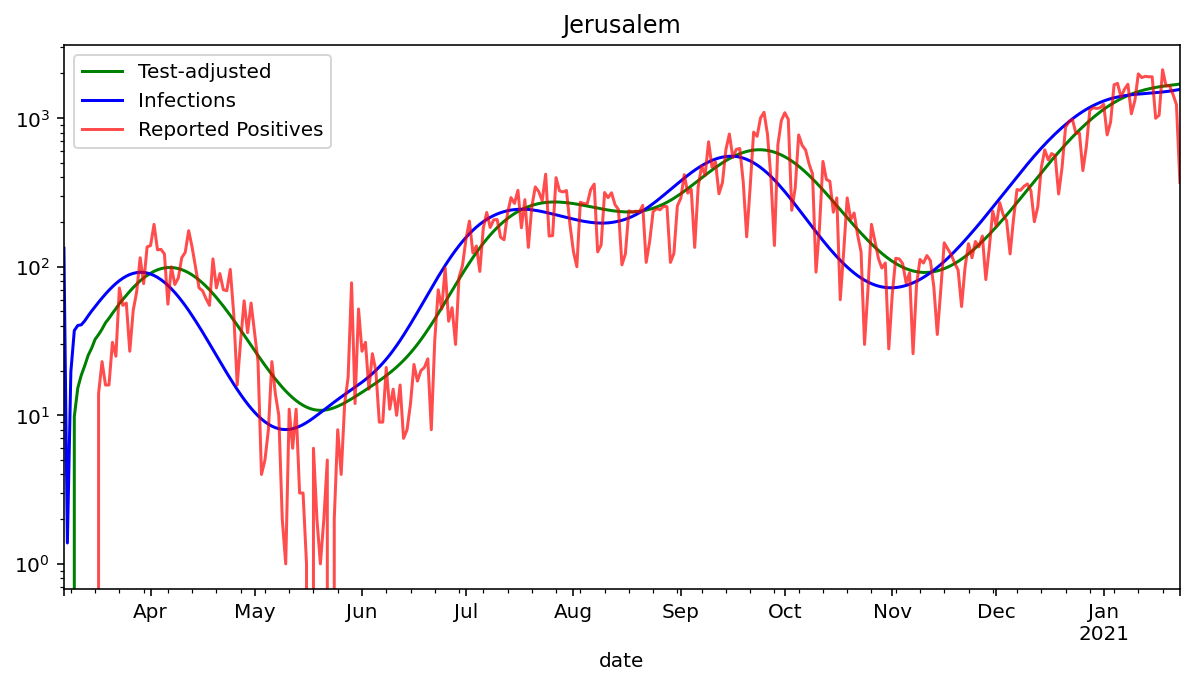

In [15]:
resultjr = summarize_inference_data(gmjr.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Jerusalem")
resultjr.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultjr.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultjr.infections.plot(c="b", label="Infections")
gmjr.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmjr.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

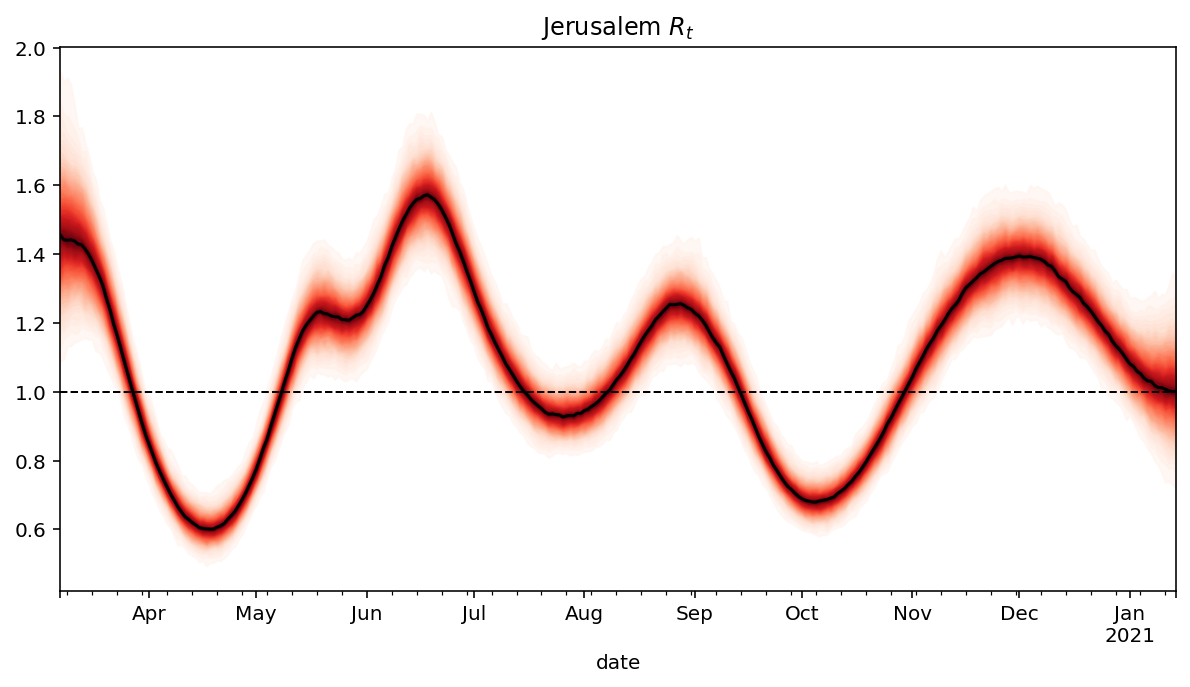

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Jerusalem $R_t$")
samples = gmjr.trace['r_t']
x=resultjr.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultjr["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [17]:
resultjr.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-25,1.378320,1.378315,1.256598,1.477147,181.439515,133.864623,148.0,148.0,100000
2020-11-26,1.384887,1.381862,1.275674,1.495184,193.338471,140.653338,136.0,136.0,100000
2020-11-27,1.389036,1.387682,1.293525,1.508780,206.246865,148.110115,161.0,161.0,100000
2020-11-28,1.390393,1.387994,1.286148,1.485930,220.260965,156.273098,82.0,82.0,100000
2020-11-29,1.390643,1.389119,1.290312,1.492267,235.422761,165.185463,134.0,134.0,100000
2020-11-30,1.394778,1.391729,1.299410,1.504735,251.720942,174.898502,237.0,237.0,100000
2020-12-01,1.394187,1.394828,1.290983,1.506860,269.165154,185.471755,188.0,188.0,100000
2020-12-02,1.393511,1.391386,1.288466,1.502897,287.900694,196.968814,270.0,270.0,100000
2020-12-03,1.392793,1.391675,1.294759,1.505615,307.994061,209.449990,224.0,224.0,100000


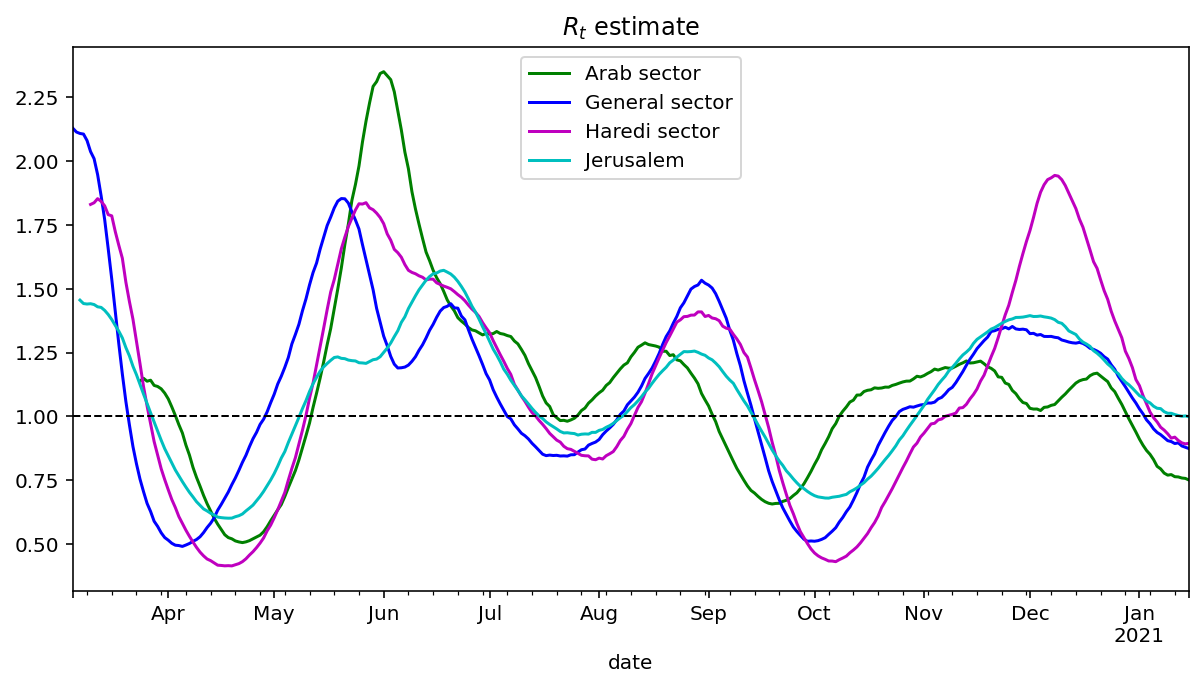

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultar["median"].plot(c="g", ls='-', label="Arab sector")
resultgn["median"].plot(c="b", ls='-', label="General sector")
resultbb["median"].plot(c="m", ls='-', label="Haredi sector")
resultjr["median"].plot(c="c", ls='-', label="Jerusalem")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [19]:
resultar.to_csv("results_arab_cities_out.csv")
resultbb.to_csv("results_haredi_cities_out.csv")
resultgn.to_csv("results_general_cities_out.csv")
resultjr.to_csv("results_jerusalem_out.csv")

{'3618', '3650', '3726', '3725', '3604', '3563'}


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1304 seconds.


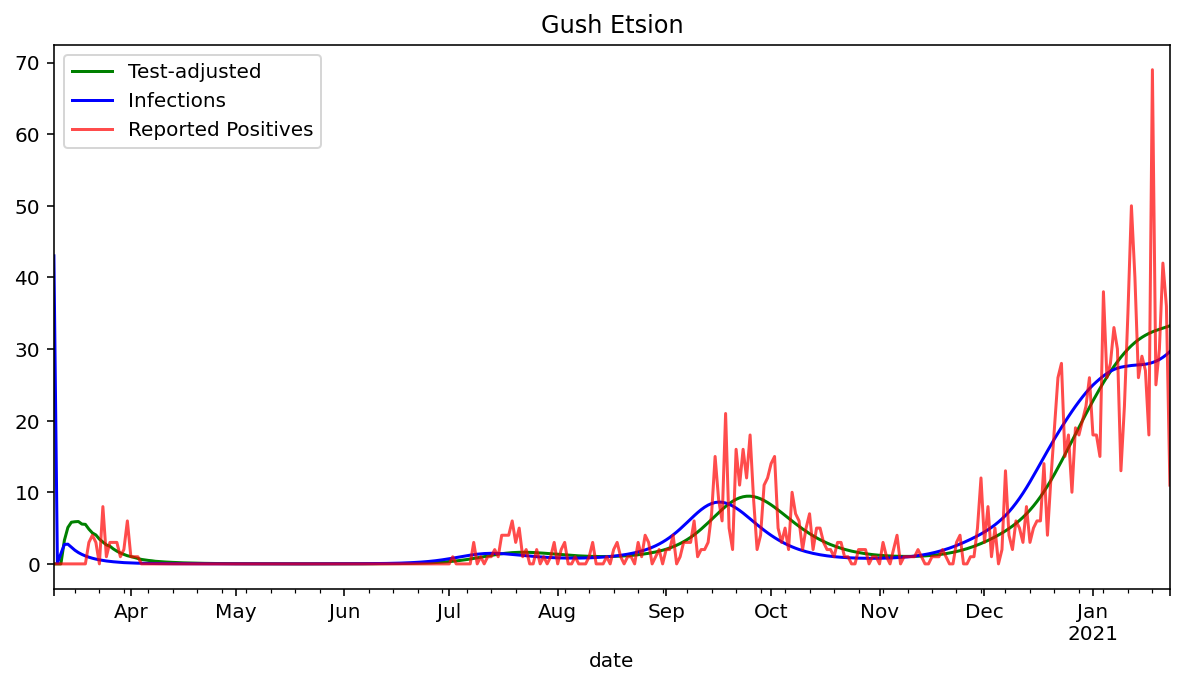

In [20]:
gush = ["3604", "3618", "3650", "3794", "3603", "3488", "3561", "3653", "3725", "3726", "1982", "1981", "3781", "3602", "3563"]
gush = set(gush) & set(list(dfcit.index.unique(0)))
print(gush)
model_gs = dfcit.loc[gush].groupby('date').sum()
gmgs = GenerativeModel(gush, model_gs, buffer_days = 10, delay=2, sigma=0.07)
gmgs.sample()

resultgs = summarize_inference_data(gmgs.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Gush Etsion")
resultgs.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgs.infections.plot(c="b", label="Infections")
gmgs.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
#plt.yscale("log")
ax.legend();

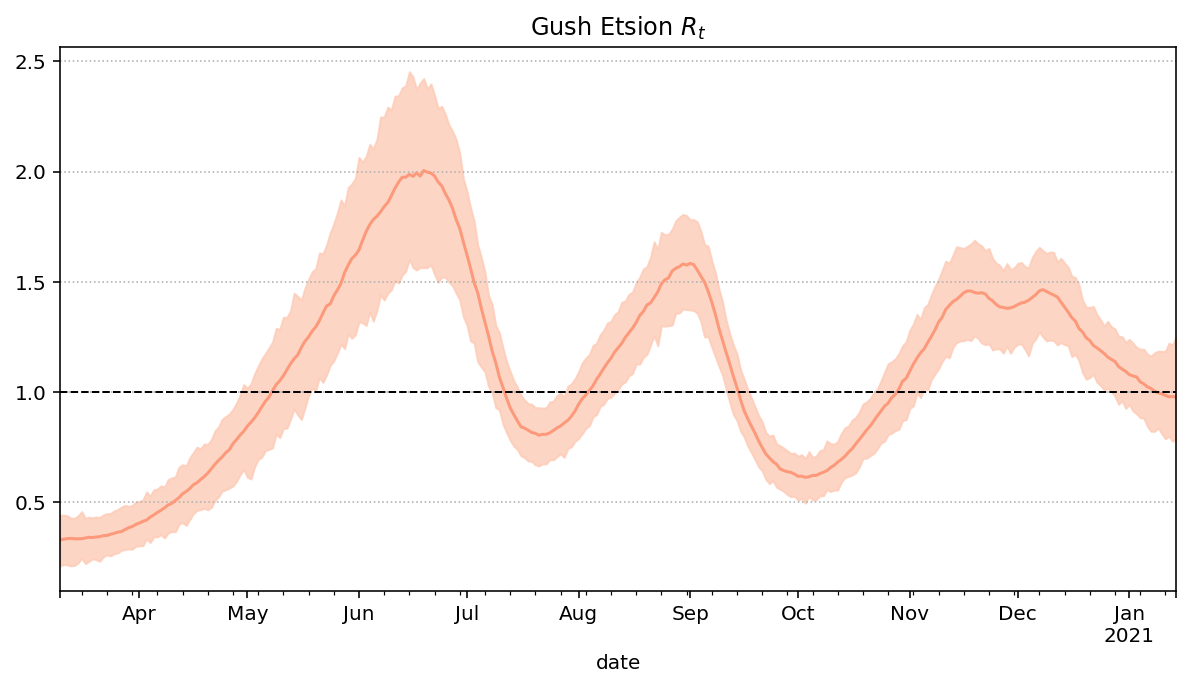

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Gush Etsion $R_t$")
samples = gmgs.trace['r_t']
x=resultgs.index
colmap = plt.get_cmap("Reds")
ax.fill_between(x, resultgs["upper_80"], resultgs["lower_80"], color=colmap(50), alpha=.8)
resultgs["median"].plot(c=colmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
